# This is a quick notebook for exploring the mechanisms within the TSAM repository

In [4]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2

In [5]:
import torch

In [6]:
# general imports
import numpy as np
import pandas as pd
import torch

from diffusers import StableDiffusionPipeline

import os
import shutil

print(torch.version.cuda)

12.6


#### TSAM imports based on run python file

In [ ]:
# the following code enables imports from the folders in the repository
# NOTE: this only affects the active kernel, not actual system path
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

In [10]:
import matplotlib.pyplot as plt
import torch
import os
import torch.nn.functional as F
from typing import List

!pip install pytorch-metric-learning

from tsam.utils import (
    load_model,
    save_image,
    save_text_sa_avg,
    get_token_ids,
    LatentOptConfig
)

import argparse
import yaml



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.8/127.8 kB 3.3 MB/s eta 0:00:00


$$ $$

$$ $$

$$ $$

## Model load in based on run file

In [11]:
from tsam.run import run_one_prompt

In [15]:
def set_notebook_args(notebook_args):
    parser = argparse.ArgumentParser(description="Run latent optimization")
    parser.add_argument("--prompt", type=str, default='a green glasses and a yellow clock',help="Text prompt")
    parser.add_argument("--model_name", type=str, default="sd1_5x_2", help="Model name")
    parser.add_argument("--device", type=str, default="cuda", help="Device to use")
    parser.add_argument("--steps", type=int, default=10, help="# of inference steps")
    parser.add_argument("--seed", type=int, default=4913, help="Random seed")
    parser.add_argument("--generation_dir", type=str, default="./generation_dir", help="Output dir")

    if notebook_args is not None:
        return parser.parse_args(
            [f'--{k}={v}' for k, v in notebook_args.items()]
        )
    else:
        raise Exception("No notebook argument dictionary")


with open('tsam/configs/config.yaml','r') as f:
    config_dict = yaml.safe_load(f)

latent_opt_config = LatentOptConfig(**config_dict)

notebook_args = {
    'prompt' : 'a green glasses and a yellow clock'
}

args = set_notebook_args(notebook_args)



prompt_list = [args.prompt]
save_flags = {
    "save_text_selfattn": False,
    "save_gen_images": True,
    "save_crossattn_sim": False
}



pipe = load_model(model_name=args.model_name, device=args.device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [ ]:
"""
run_one_prompt(
        prompt=args.prompt,
        pipe=pipe,
        latent_opt_config=latent_opt_config,
        device=args.device,
        generation_dir=args.generation_dir,
        seed=args.seed,
        num_inference_steps=args.steps,
        save_flags=save_flags,
        model_name=args.model_name
    )
"""
print()

In [17]:
from pathlib import Path
from datetime import datetime
from tsam.logger.bias_logger import BiasLogger

def bias_reduced_generation_with_logger(prompt, biased_prompts, num_inference_steps=10, base_log_dir="bias_logs"):

    base_log_dir = Path(base_log_dir)
    base_log_dir.mkdir(exist_ok=True)
    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = base_log_dir / run_id
    save_dir.mkdir(parents=True, exist_ok=True)

    # Initialize logger with optional decode function
    logger = BiasLogger(save_dir=save_dir, decode_fn=getattr(pipe, "decode_latent_if_needed", None))

    pipe.text_encoder.to("cuda")

    # Prepare biased prompt embeddings
    biased_prompt_embeds = []
    for b_prompt in biased_prompts:
        b_text_inputs = pipe.tokenizer(
            b_prompt,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        b_text_input_ids = b_text_inputs.input_ids.to(pipe.text_encoder.device)
        b_prompt_embeds = pipe.text_encoder(b_text_input_ids)[0].to("cuda")
        biased_prompt_embeds.append(b_prompt_embeds)
    # Get token ids for main and biased prompts
    _, eos_idx = get_token_ids(prompt=prompt, tokenizer=pipe.tokenizer)
    _, biased_eos_idx = get_token_ids(prompt=biased_prompts[0], tokenizer=pipe.tokenizer)

    pipe.attn_fetch_x.set_processor(unet=pipe.unet)
    # Define steps to save attention maps
    steps_to_save_attention_maps = list(range(num_inference_steps))
    max_iter_to_alter = latent_opt_config.max_iter_to_alter
    iterative_refinement_steps = latent_opt_config.iterative_refinement_steps
    if not latent_opt_config.update_latent:
        max_iter_to_alter = 0
        iterative_refinement_steps = []

    # Step callback to log everything per step
    def step_callback(step, latent, attn_maps, bias_loss=None, intermediate_image=None):
        for layer_name, t in attn_maps.items():
            logger.log_attention(layer_name, t)
        if bias_loss is not None:
            logger.log_bias_loss(bias_loss)
        if intermediate_image is not None:
            logger.log_image(intermediate_image)
    # Main generation call
    final_image = pipe.bias_reduced_call(
        prompt=prompt,
        generator=torch.Generator("cuda").manual_seed(1234),
        num_inference_steps=num_inference_steps,
        max_iter_to_alter=max_iter_to_alter,
        steps_to_save_attention_maps=steps_to_save_attention_maps,
        latent_opt_config=latent_opt_config,
        biased_prompt_texts=biased_prompts,
        biased_prompt_embeds=biased_prompt_embeds,
        biased_eos_idx=biased_eos_idx
    )
    # Save all logged data to disk
    logger.finalize(clear_after_save=True)

    return final_image

## Bias loss function tests

What loss function to enforce between two bias prompt cross attentions and self attentions?

- Just cross attentions:
   - Enforce similarity between concept maps:
      - sim_ca_cosine
      - sim_ca_mse
   - Enforce difference between concept maps:
      - diff_ca_cosine
      - diff_ca_mse
   - Could consider having a schedule of sim or diff thresholds to enforce overtime.
$$ $$
- Cross attentions and self attentions:
   - Enforce even cosine similarity between concept ca and concept prompt sa
      - Threshold similarity (50/50, 60/40, etc)
      - sim_ca_sa_cosine
$$ $$
- loss function details:
   - display: all or one
   - max_cnt: maximum interation count, default 30
   - block_class: block class to grab cross attentions from
   - total_map_size: total map size of desired cross attention layer (s*s)
   - balance_beta: multiplier for balance importance


Getting text self attention matrices for bias prompts
num latent channels: 4
step sizes [5.   4.97 4.95 4.92 4.9  4.87 4.85 4.82 4.8  4.77 4.74 4.72 4.69 4.66
 4.64 4.61 4.58 4.56 4.53 4.5  4.47 4.44 4.42 4.39 4.36 4.33 4.3  4.27
 4.24 4.21 4.18 4.15 4.12 4.09 4.06 4.03 4.   3.97 3.94 3.91 3.87 3.84
 3.81 3.77 3.74 3.71 3.67 3.64 3.61 3.57 3.54]
num_warmup_steps: 1
latents shape: torch.Size([1, 4, 64, 64])
steps_to_save_attention_map: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
latent_opt_config.attn_like_loss: None
max_iter_to_alter: 30
iterative_refinement_steps: []
device: cuda:0
off-loading VAE and text_encoder to CPU during latent optimization


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


attn loss: 1.791015625
updated latent (step 0)
attn loss: 1.787109375
updated latent (step 1)
attn loss: 1.7890625
updated latent (step 2)
attn loss: 1.775390625
updated latent (step 3)
attn loss: 1.765625
updated latent (step 4)
attn loss: 1.7685546875
updated latent (step 5)
attn loss: 1.75
updated latent (step 6)
attn loss: 1.751953125
updated latent (step 7)
attn loss: 1.7431640625
updated latent (step 8)
attn loss: 1.7431640625
updated latent (step 9)
attn loss: 1.736328125
Starting bias iterative refinement for step: 10
A_np shape: (64, 64)


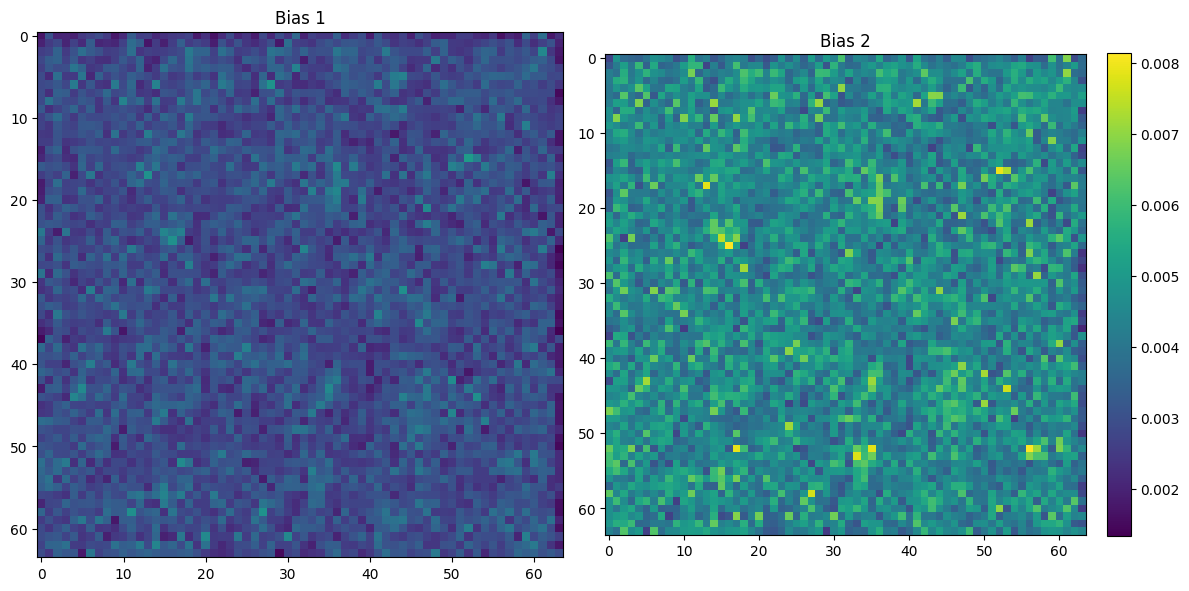

A_np shape: (32, 32)


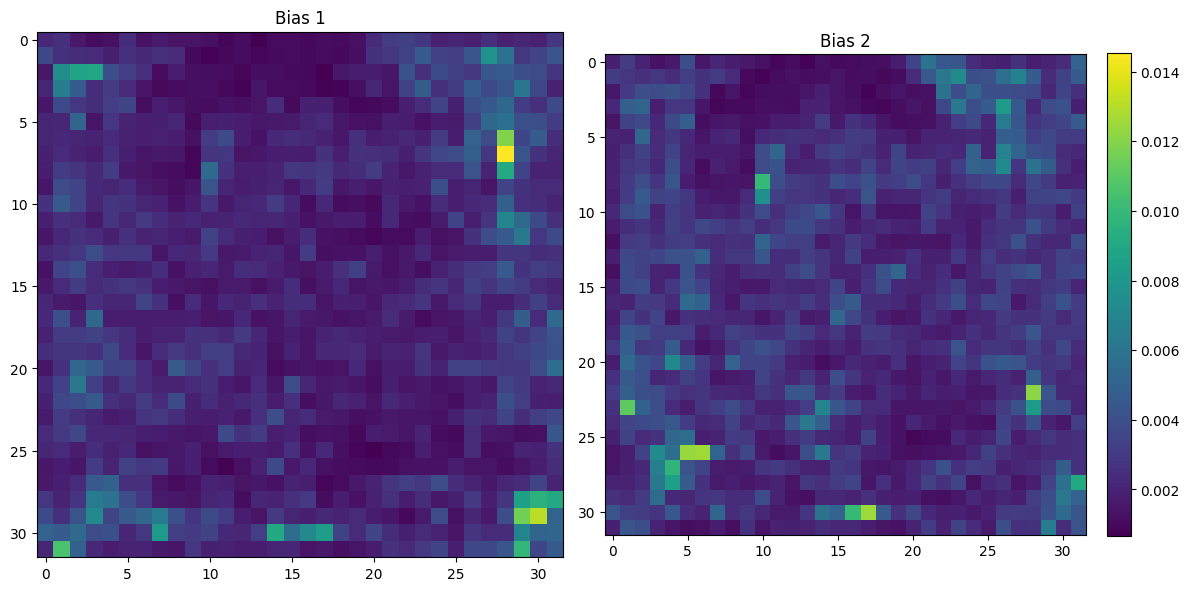

A_np shape: (16, 16)


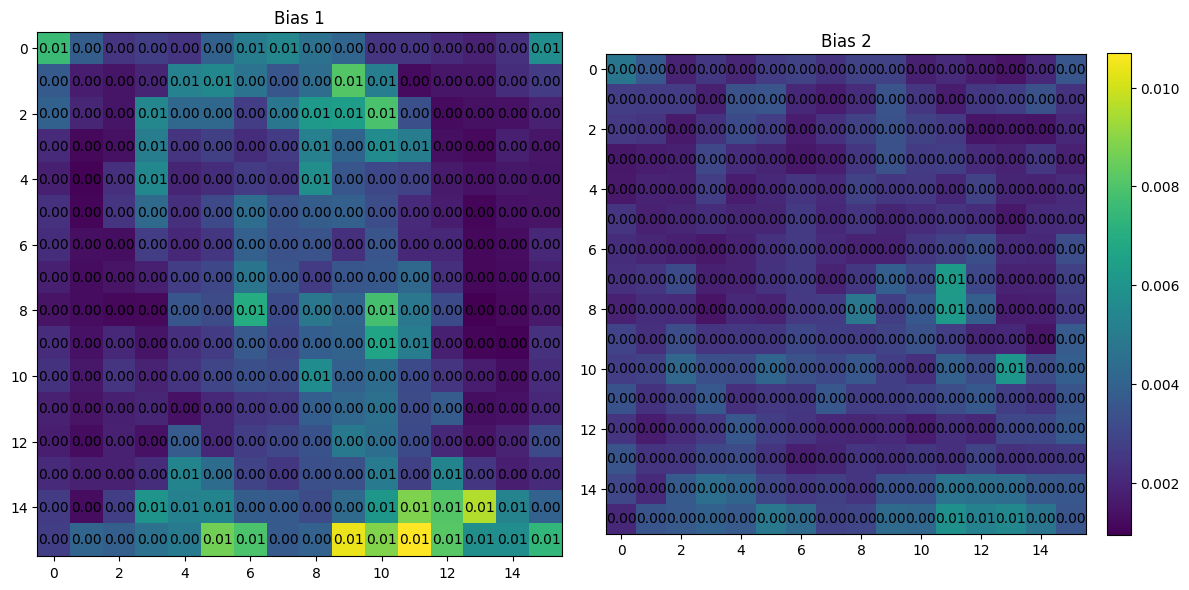

A_np shape: (16, 16)


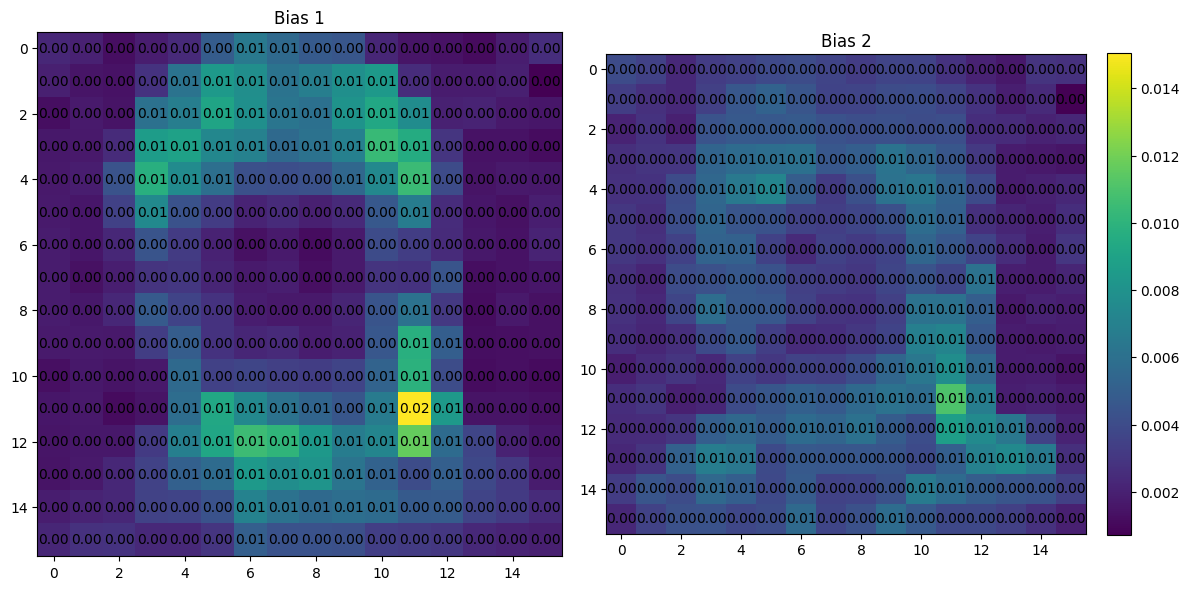

A_np shape: (32, 32)


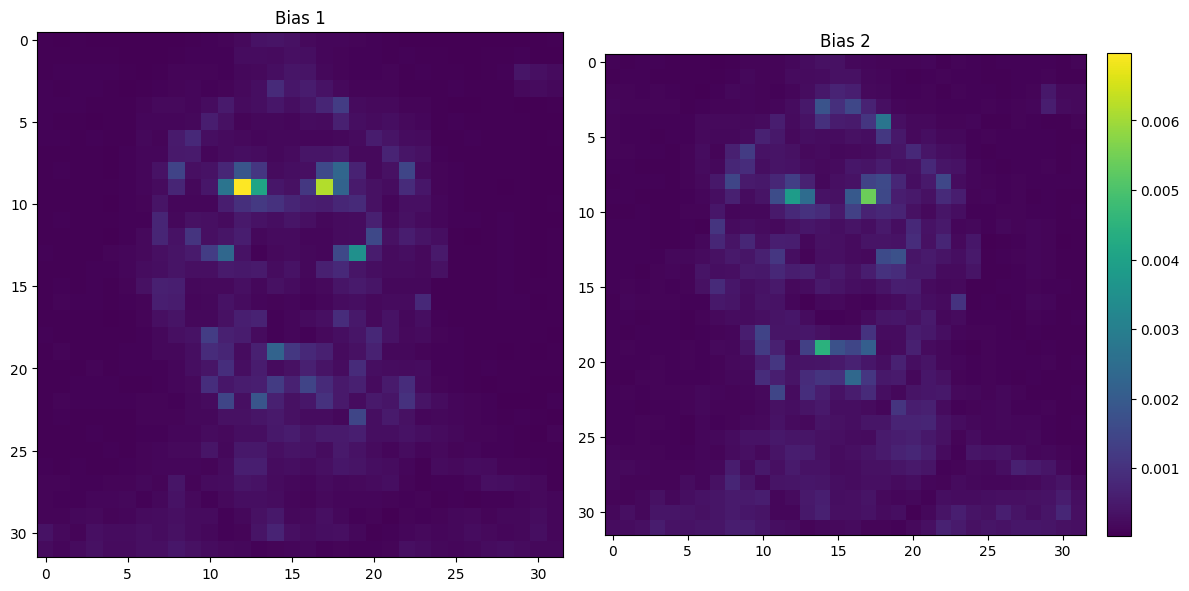

A_np shape: (64, 64)


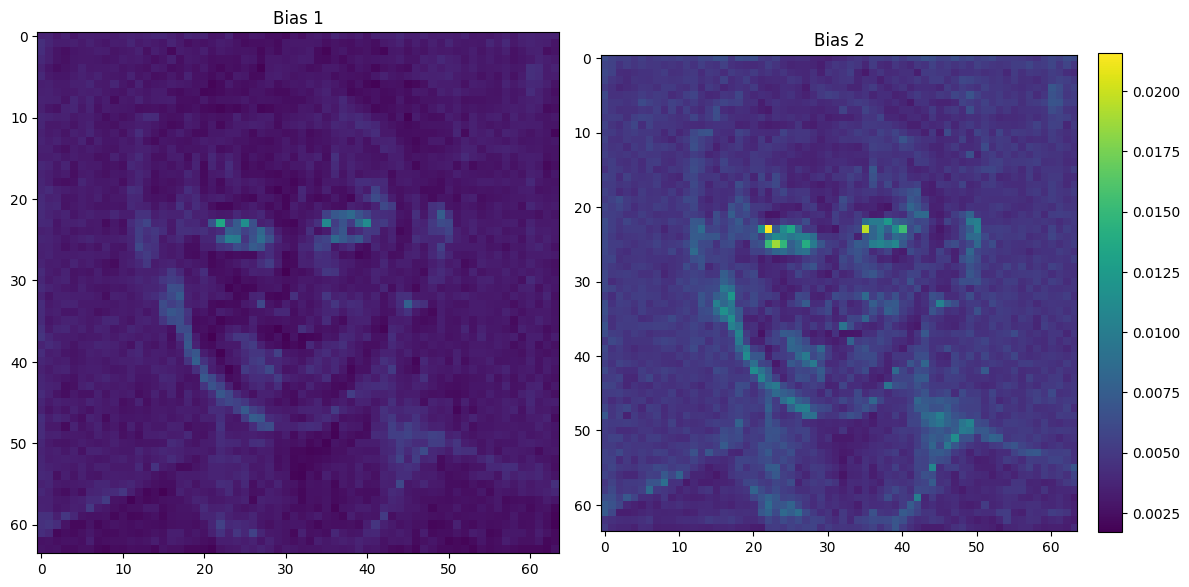

Bias concepts cosine similarity balanced loss: 3.763671875			 (avg_cos_loss, abs_diff) : (3.470703125,0.29296875)
Bias concepts cosine similarity balanced loss: 3.650390625			 (avg_cos_loss, abs_diff) : (3.435546875,0.21484375)
Bias concepts cosine similarity balanced loss: 3.478515625			 (avg_cos_loss, abs_diff) : (3.390625,0.087890625)
Bias concepts cosine similarity balanced loss: 3.400390625			 (avg_cos_loss, abs_diff) : (3.37109375,0.029296875)
Bias concepts cosine similarity balanced loss: 3.388671875			 (avg_cos_loss, abs_diff) : (3.349609375,0.0390625)
Bias concepts cosine similarity balanced loss: 3.3515625			 (avg_cos_loss, abs_diff) : (3.33203125,0.01953125)
Bias concepts cosine similarity balanced loss: 3.357421875			 (avg_cos_loss, abs_diff) : (3.30859375,0.048828125)
Bias concepts cosine similarity balanced loss: 3.30859375			 (avg_cos_loss, abs_diff) : (3.2890625,0.01953125)
Bias concepts cosine similarity balanced loss: 3.34375			 (avg_cos_loss, abs_diff) : (3.265625,0.

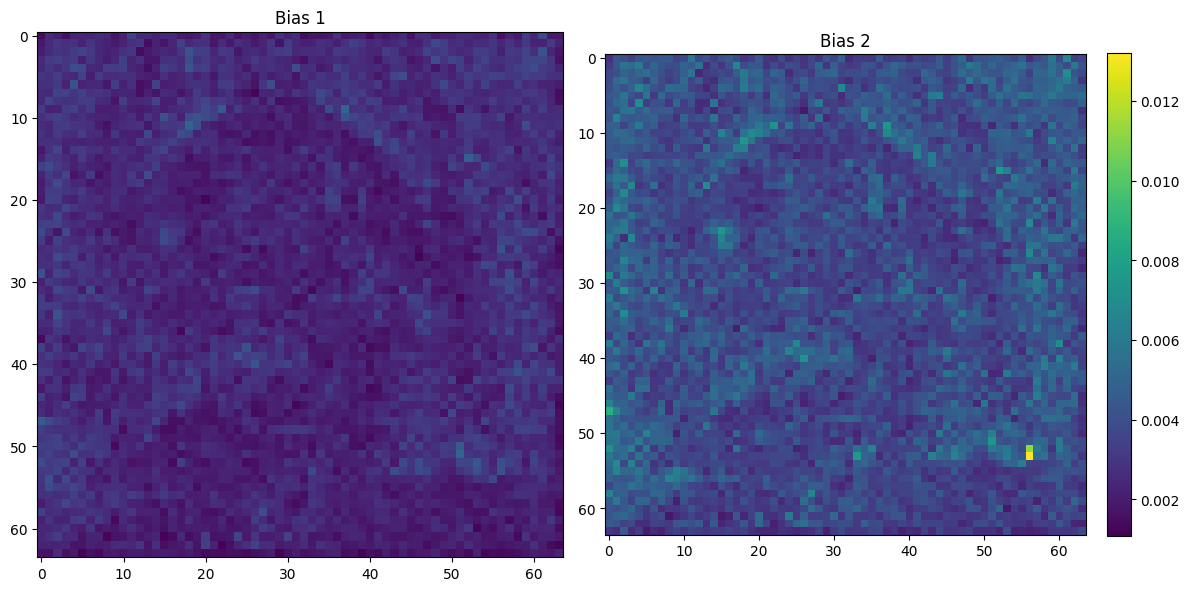

A_np shape: (32, 32)


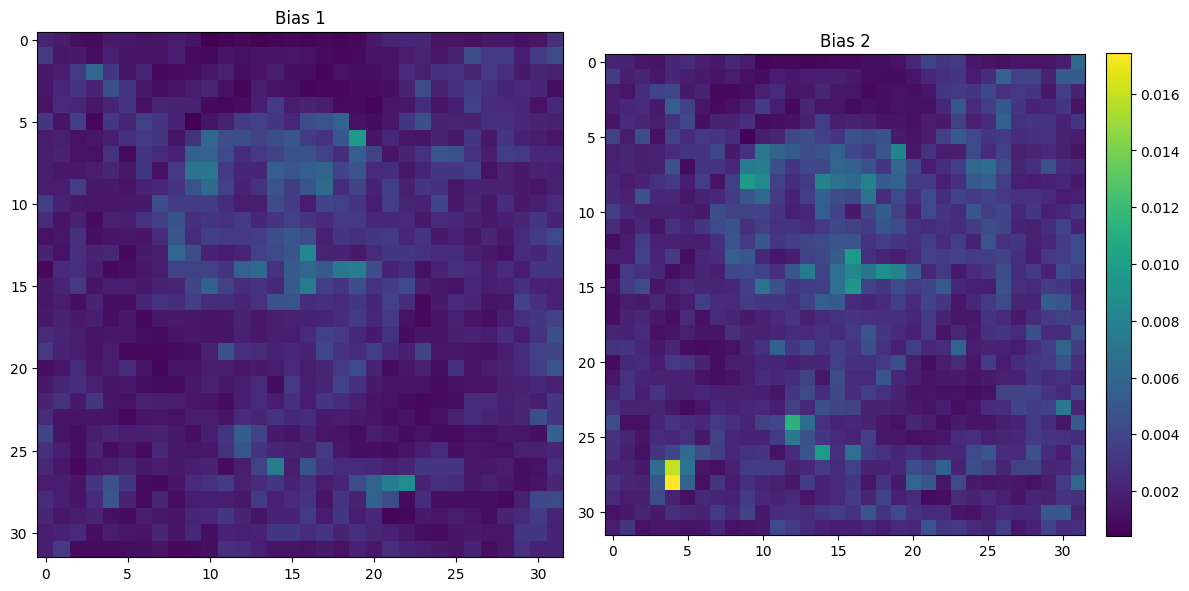

A_np shape: (16, 16)


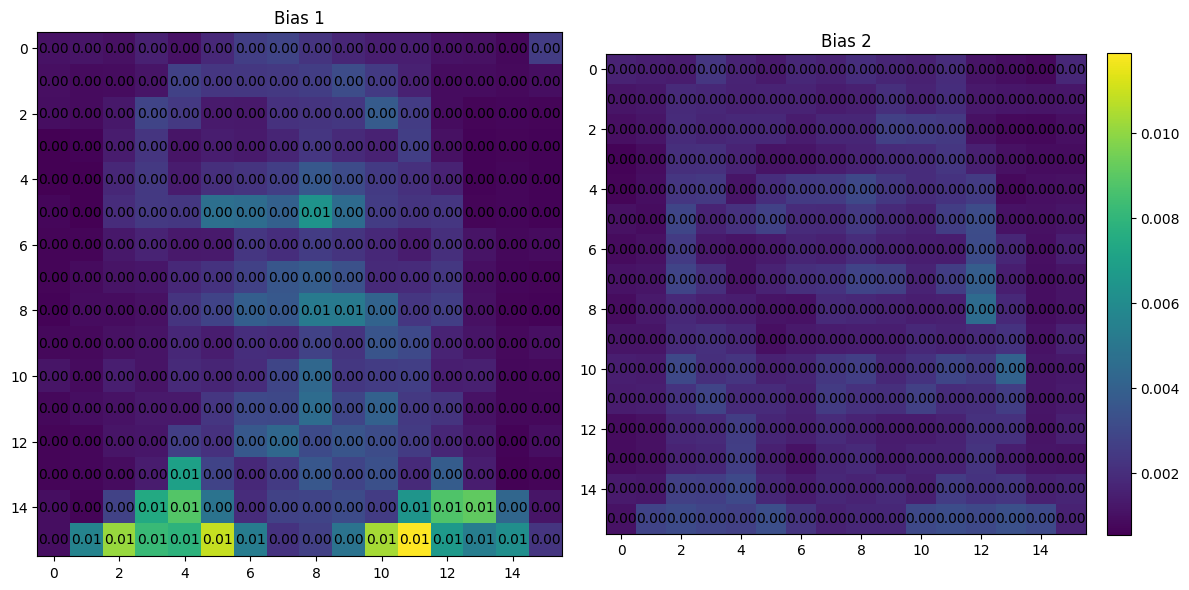

A_np shape: (16, 16)


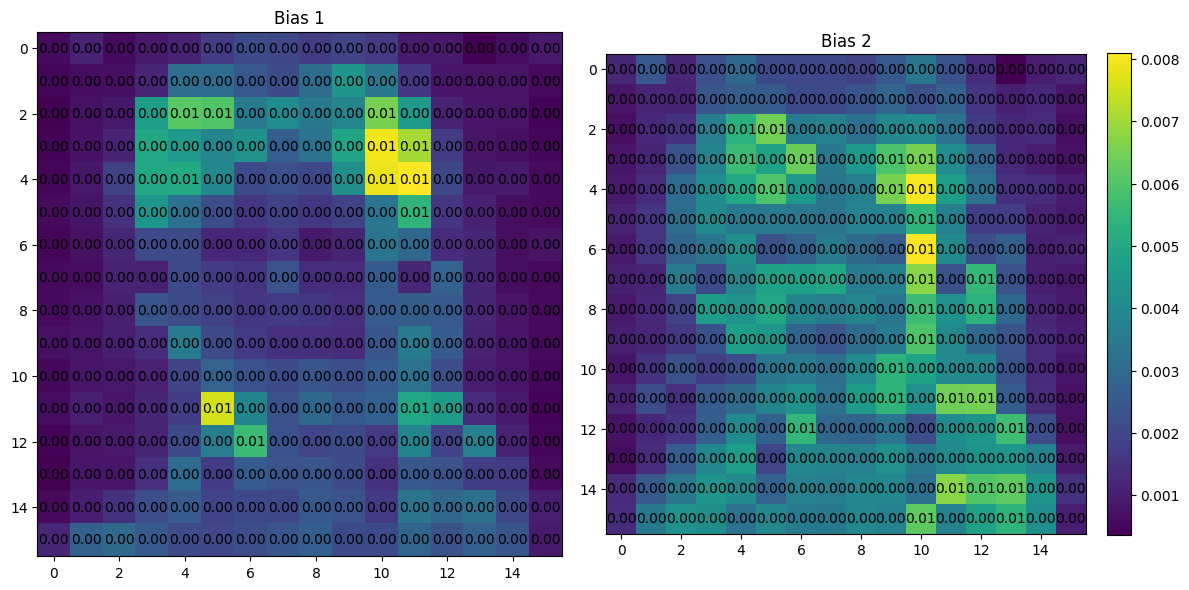

A_np shape: (32, 32)


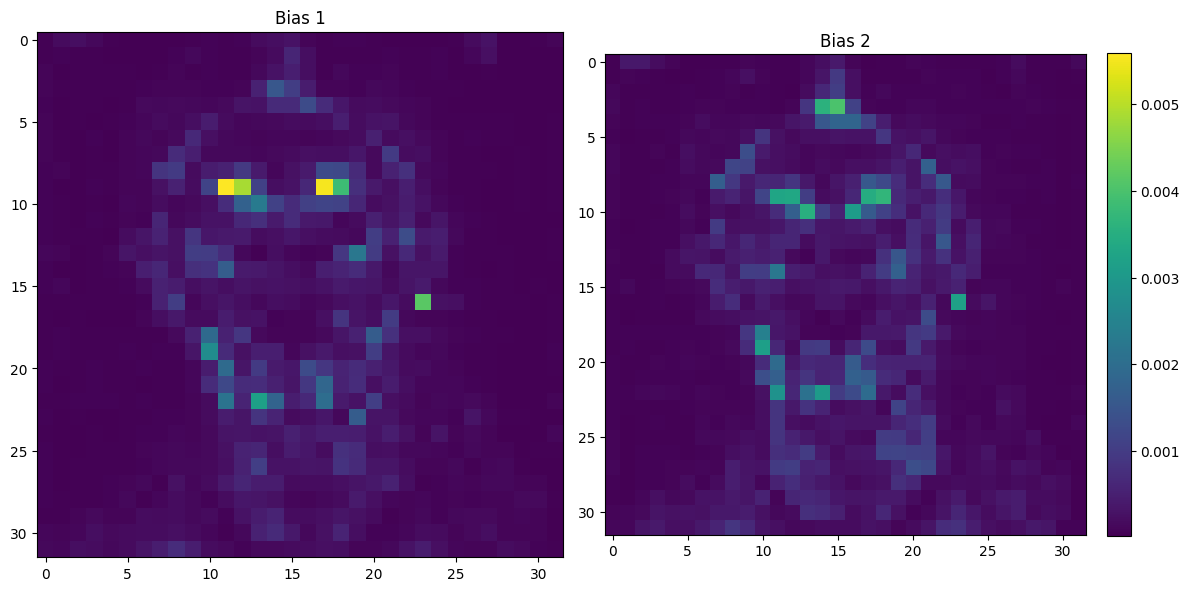

A_np shape: (64, 64)


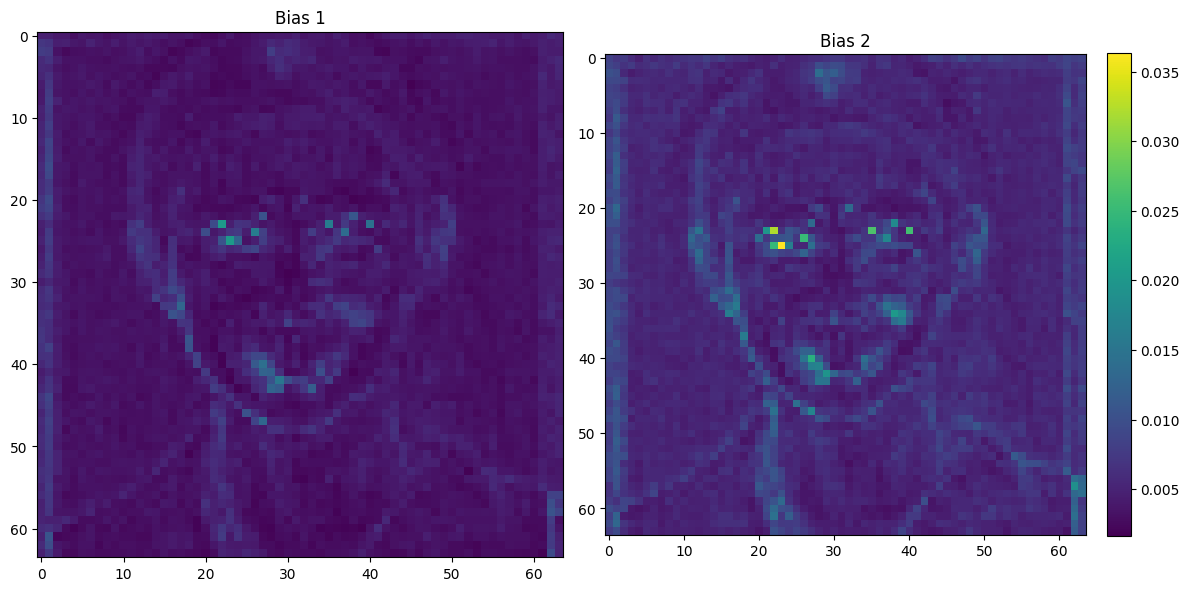

Bias concepts cosine similarity balanced loss: 3.193359375			 (avg_cos_loss, abs_diff) : (2.890625,0.302734375)
Bias concepts cosine similarity balanced loss: 3.306640625			 (avg_cos_loss, abs_diff) : (3.091796875,0.21484375)
Bias concepts cosine similarity balanced loss: 3.181640625			 (avg_cos_loss, abs_diff) : (3.0546875,0.126953125)
Bias concepts cosine similarity balanced loss: 3.037109375			 (avg_cos_loss, abs_diff) : (3.0078125,0.029296875)
Bias concepts cosine similarity balanced loss: 2.9921875			 (avg_cos_loss, abs_diff) : (2.93359375,0.05859375)
Bias concepts cosine similarity balanced loss: 2.845703125			 (avg_cos_loss, abs_diff) : (2.845703125,0.0)
Bias concepts cosine similarity balanced loss: 2.822265625			 (avg_cos_loss, abs_diff) : (2.7734375,0.048828125)
Bias concepts cosine similarity balanced loss: 2.880859375			 (avg_cos_loss, abs_diff) : (2.8515625,0.029296875)
Bias concepts cosine similarity balanced loss: 2.78125			 (avg_cos_loss, abs_diff) : (2.78125,0.0)
Bias 

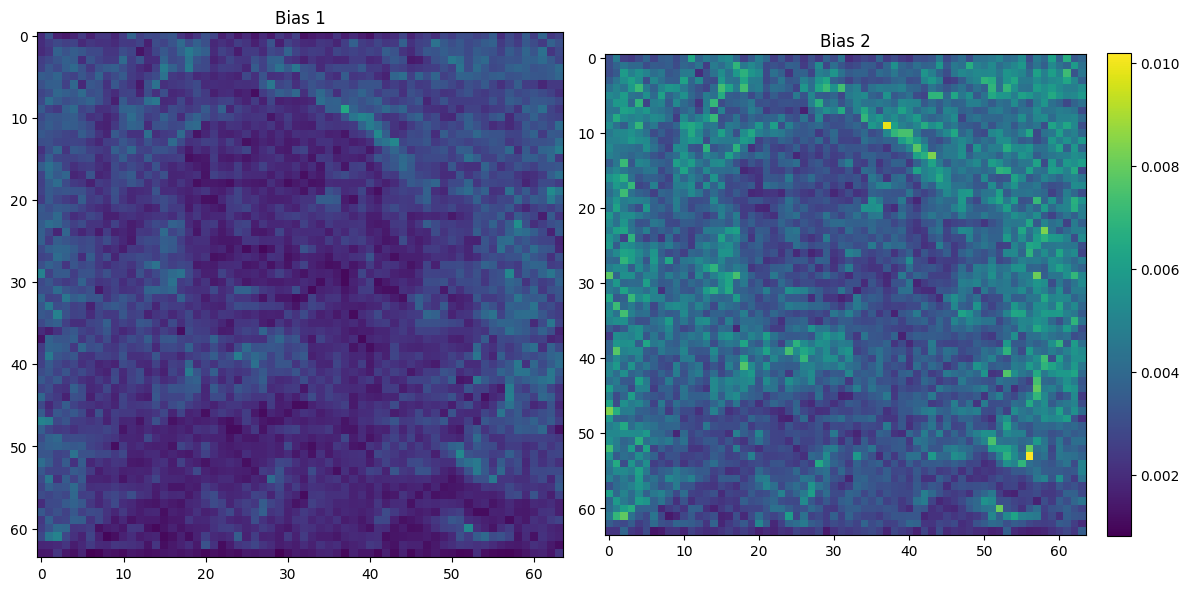

A_np shape: (32, 32)


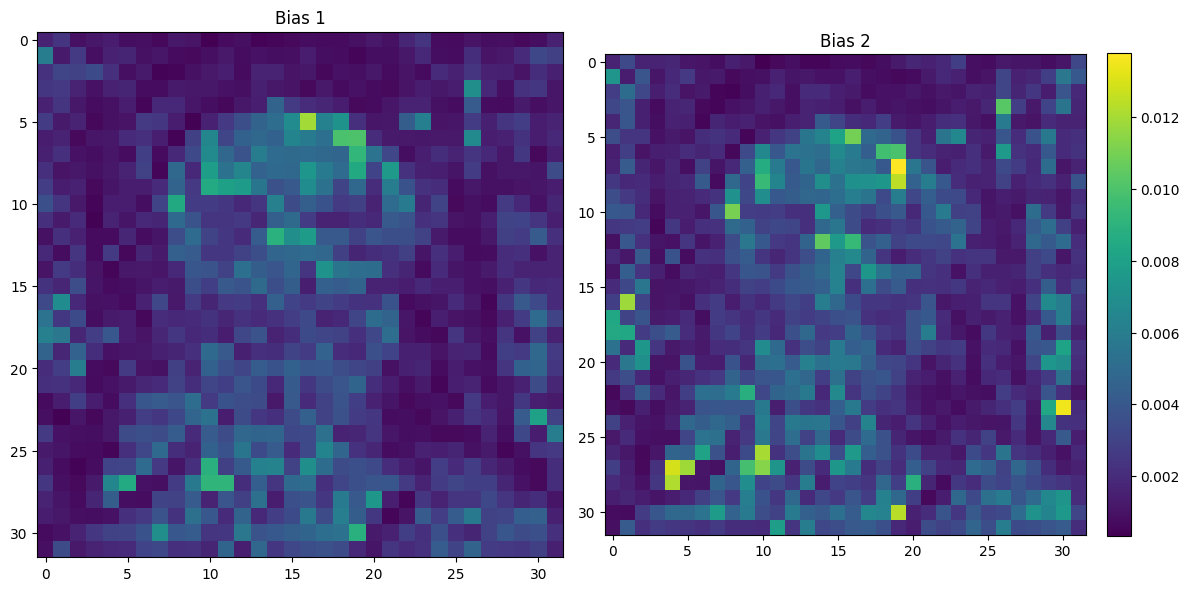

A_np shape: (16, 16)


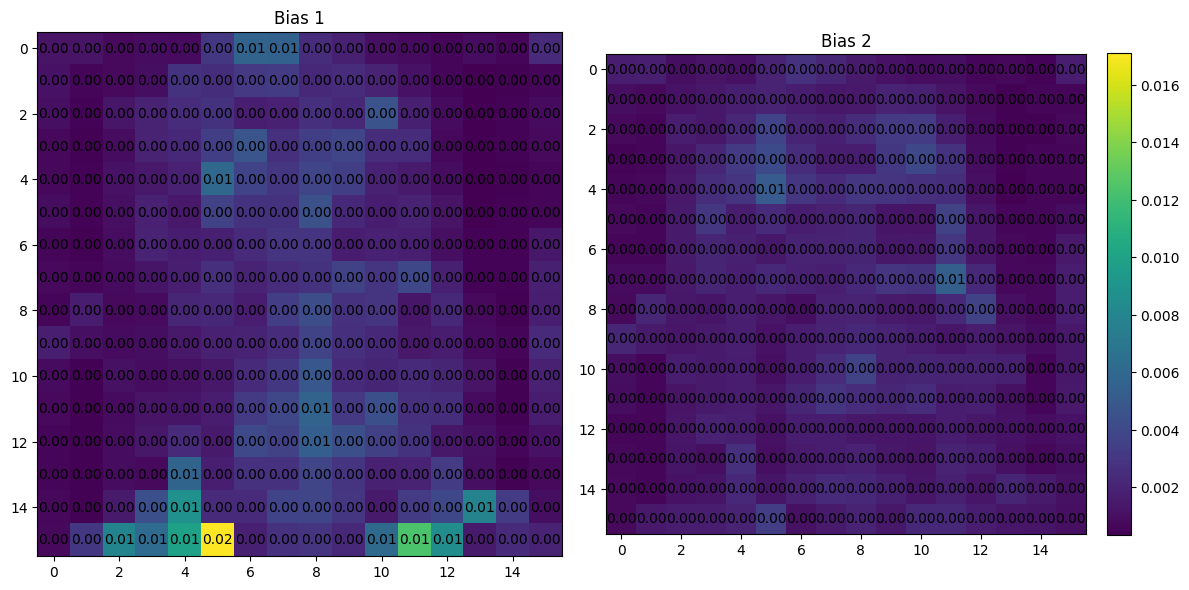

A_np shape: (16, 16)


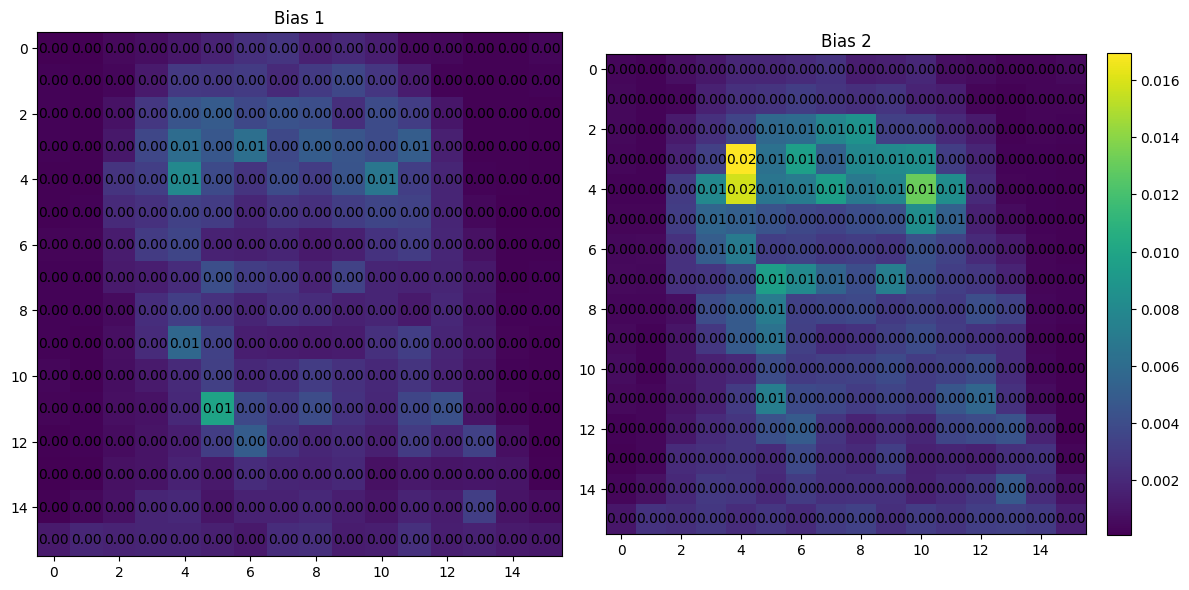

A_np shape: (32, 32)


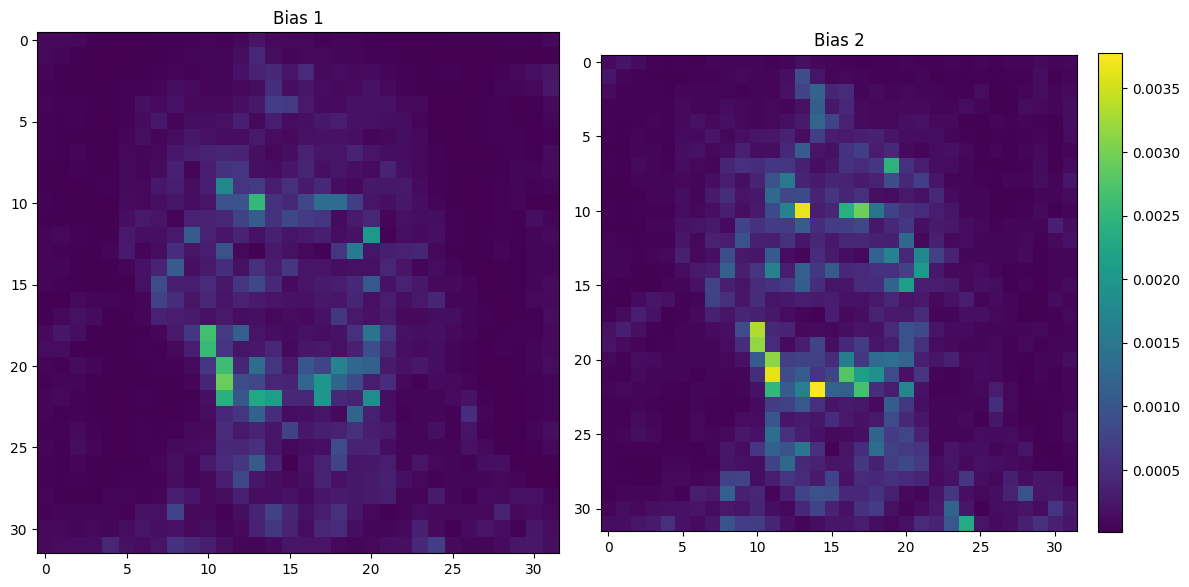

A_np shape: (64, 64)


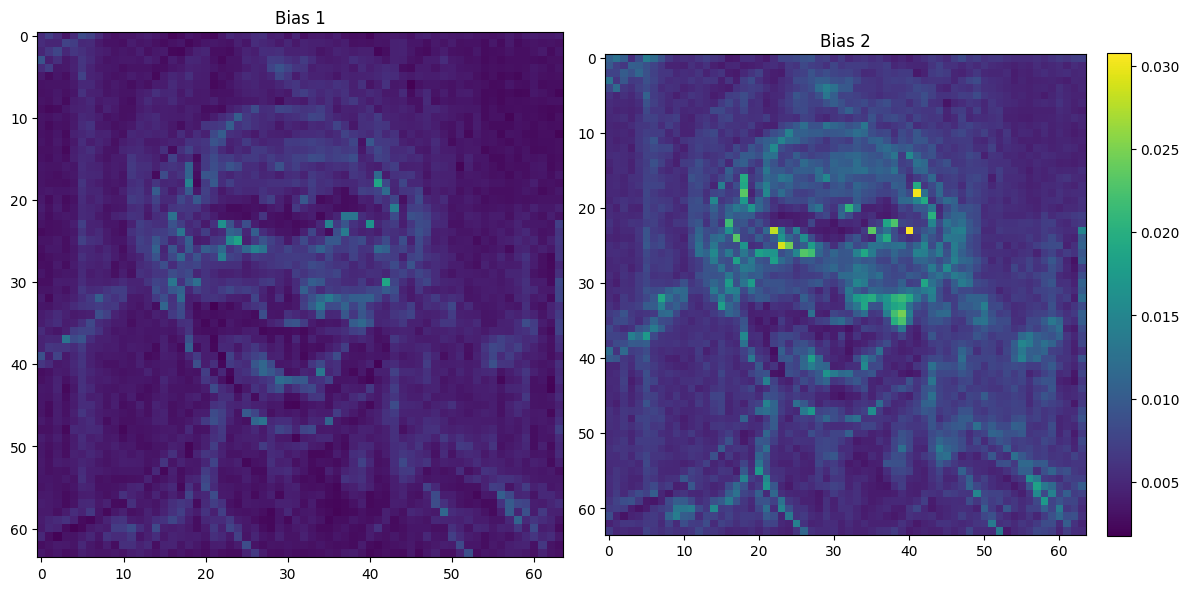

Bias concepts cosine similarity balanced loss: 2.333984375			 (avg_cos_loss, abs_diff) : (2.24609375,0.087890625)
Bias concepts cosine similarity balanced loss: 2.240234375			 (avg_cos_loss, abs_diff) : (2.19140625,0.048828125)
Bias concepts cosine similarity balanced loss: 2.1640625			 (avg_cos_loss, abs_diff) : (2.14453125,0.01953125)
Bias concepts cosine similarity balanced loss: 2.197265625			 (avg_cos_loss, abs_diff) : (2.1484375,0.048828125)
Bias concepts cosine similarity balanced loss: 2.087890625			 (avg_cos_loss, abs_diff) : (2.068359375,0.01953125)
Bias concepts cosine similarity balanced loss: 2.068359375			 (avg_cos_loss, abs_diff) : (2.048828125,0.01953125)
Bias concepts cosine similarity balanced loss: 2.0703125			 (avg_cos_loss, abs_diff) : (2.01171875,0.05859375)
Bias concepts cosine similarity balanced loss: 2.021484375			 (avg_cos_loss, abs_diff) : (2.001953125,0.01953125)
Bias concepts cosine similarity balanced loss: 2.04296875			 (avg_cos_loss, abs_diff) : (1.9687

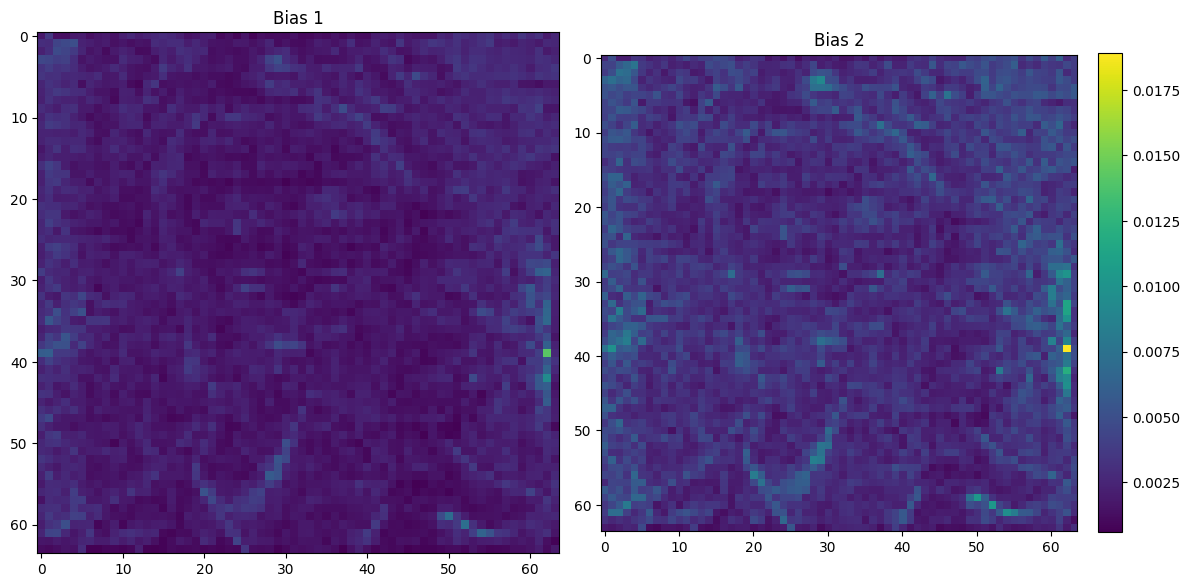

A_np shape: (32, 32)


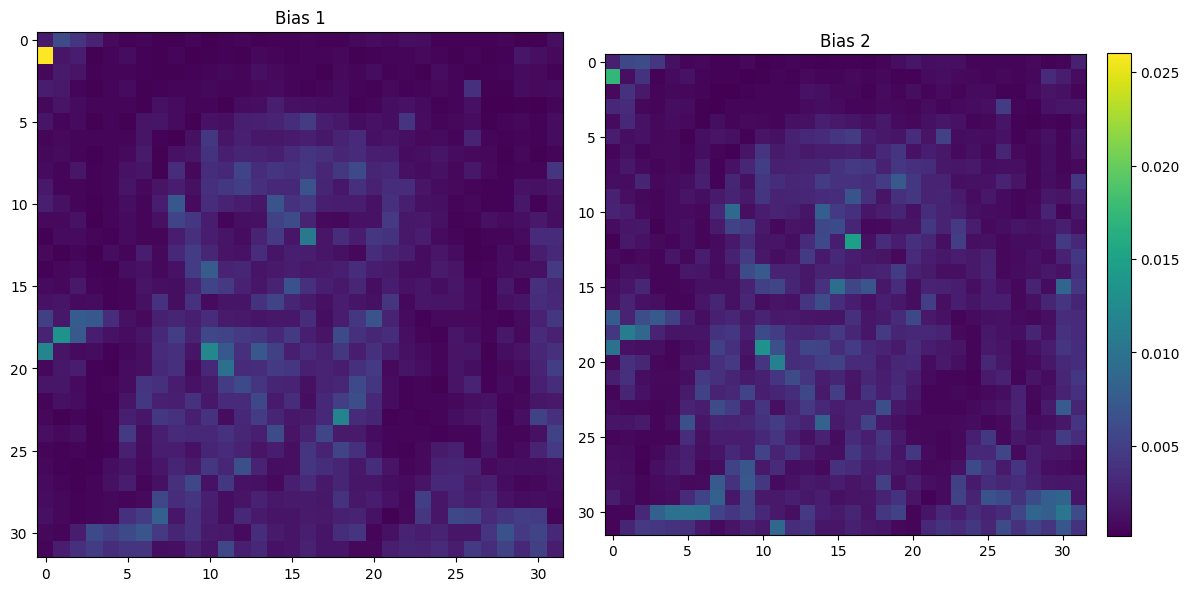

A_np shape: (16, 16)


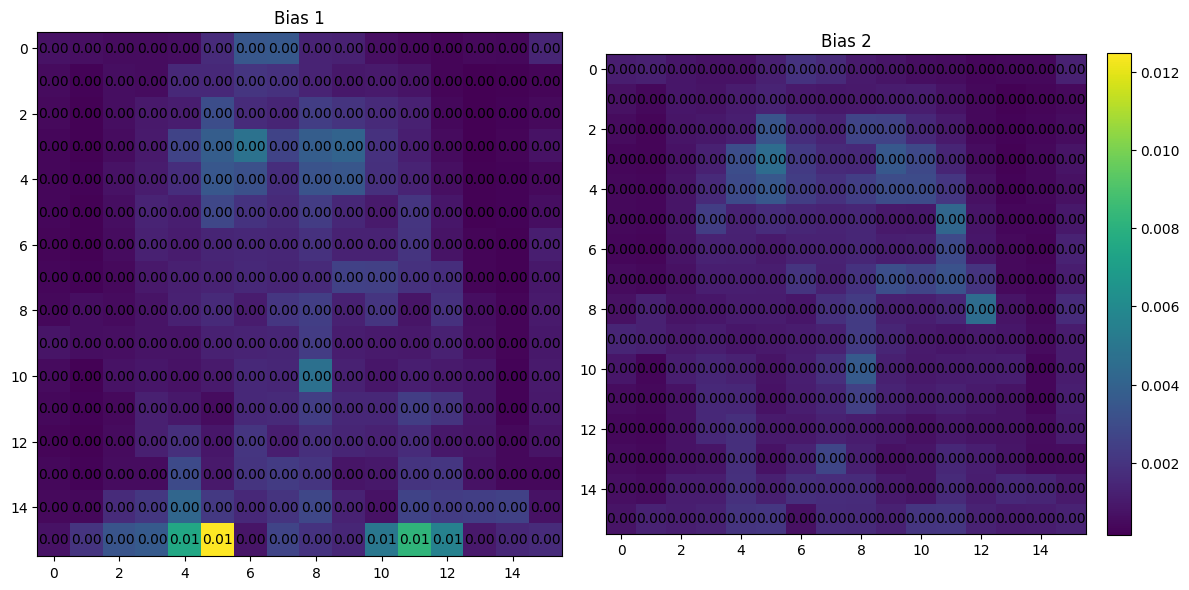

A_np shape: (16, 16)


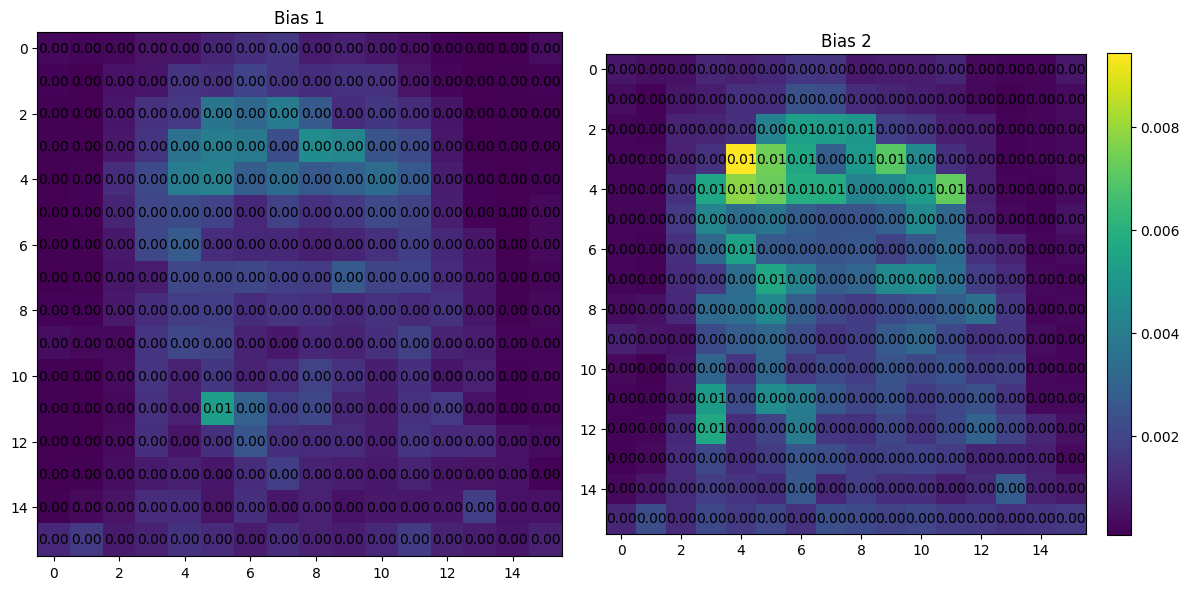

A_np shape: (32, 32)


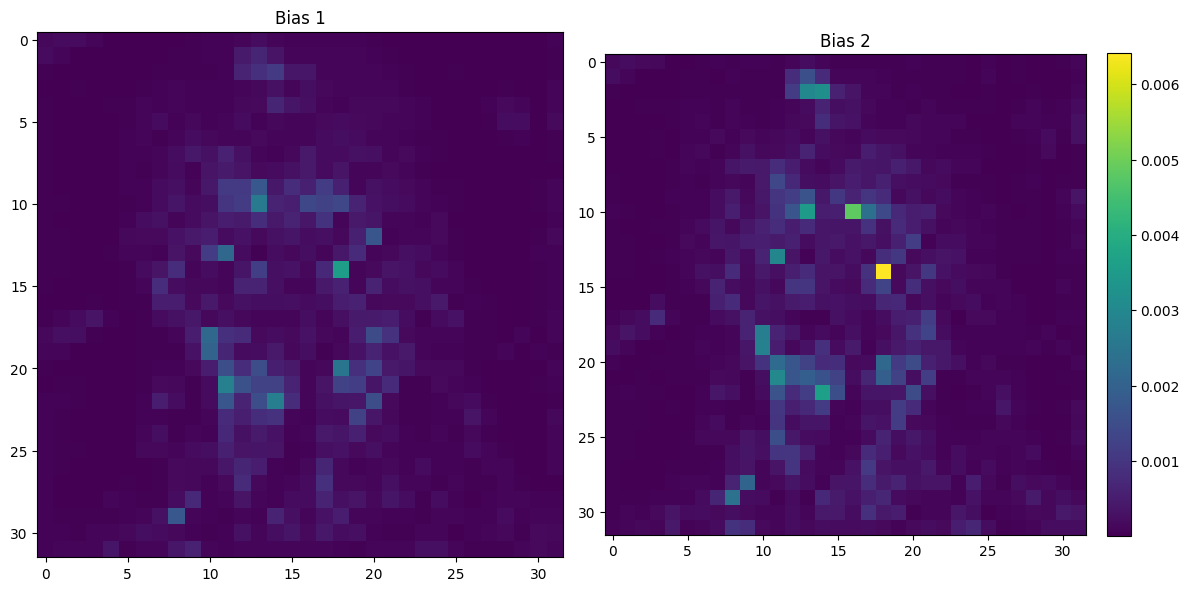

A_np shape: (64, 64)


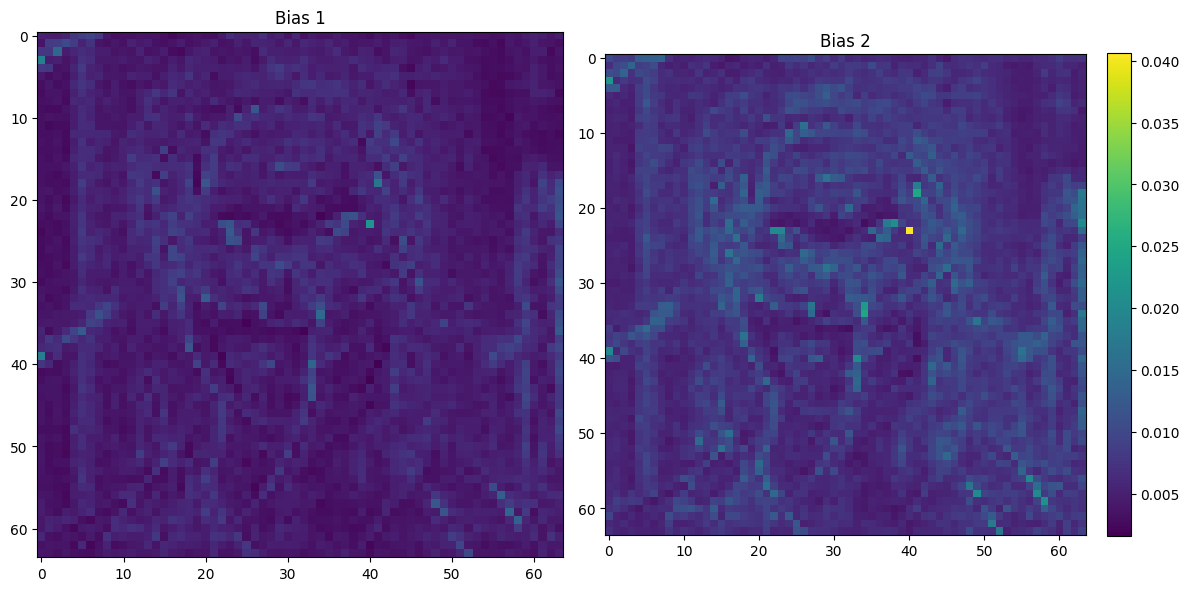

Bias concepts cosine similarity balanced loss: 2.7734375			 (avg_cos_loss, abs_diff) : (2.6953125,0.078125)
Bias concepts cosine similarity balanced loss: 2.341796875			 (avg_cos_loss, abs_diff) : (2.29296875,0.048828125)
Bias concepts cosine similarity balanced loss: 2.1875			 (avg_cos_loss, abs_diff) : (2.1484375,0.0390625)
Bias concepts cosine similarity balanced loss: 2.123046875			 (avg_cos_loss, abs_diff) : (2.07421875,0.048828125)
Bias concepts cosine similarity balanced loss: 2.01953125			 (avg_cos_loss, abs_diff) : (1.9912109375,0.029296875)
Bias concepts cosine similarity balanced loss: 1.96875			 (avg_cos_loss, abs_diff) : (1.94921875,0.01953125)
Bias concepts cosine similarity balanced loss: 1.9541015625			 (avg_cos_loss, abs_diff) : (1.8857421875,0.068359375)
Bias concepts cosine similarity balanced loss: 1.8681640625			 (avg_cos_loss, abs_diff) : (1.8583984375,0.009765625)
Bias concepts cosine similarity balanced loss: 1.8955078125			 (avg_cos_loss, abs_diff) : (1.8027343

In [18]:
# disable T-SAM iterative function
latent_opt_config.iterative_refinement_steps = []

# bias map display settings
latent_opt_config.show_first_bias_map = True
latent_opt_config.show_last_bias_map = True
latent_opt_config.show_first_bias_ca_sa = False
latent_opt_config.show_last_bias_ca_sa = False


latent_opt_config.bias_refinement_steps = [10, 20, 30, 40]

latent_opt_config.bias_loss_function = "sim_ca_sa_cosine"
latent_opt_config.bias_loss_function_details = {'display' : 'all',
                                                'block_class': None,
                                                'total_map_size': None,
                                                'balance_beta' : 0.001,
                                                'balance_beta': 5,
                                                'average_beta': 1}
latent_opt_config.bias_loss_threshold = 0.01


main_prompt = "A photo of the face of a nurse"

biased_prompts = ["A photo of the face of a nurse and male", "A photo of the face of a nurse and female"]

image, attention_maps = bias_reduced_generation_with_logger(main_prompt, biased_prompts, num_inference_steps=50)

In [ ]:
plt.imshow(image[0])

In [ ]:
hasattr(pipe.text_encoder.config, "use_attention_mask") and pipe.text_encoder.config.use_attention_mask

False

In [ ]:
biased_prompt = "A photo of the face of a nurse and female"

In [ ]:
text_inputs

{'input_ids': tensor([[49406,   320,  1125,   539,   518,  1710,   539,   320, 10058,   537,
          3970, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])}

In [ ]:
image, all_maps = pipe(prompt="A photo of the face of a nurse and male" ,
                        generator=torch.Generator("cuda").manual_seed(1234),
                        num_inference_steps=10,
                        max_iter_to_alter=50,
                        iterative_refinement_steps=latent_opt_config.iterative_refinement_steps,
                        steps_to_save_attention_maps=[],
                        latent_opt_config = latent_opt_config
                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\brandon\anaconda3\envs\CS5864\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

KeyboardInterrupt



In [ ]:
pipe.scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.32.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [ ]:
pipe.scheduler.set_timesteps(num_inference_steps=10, device="cpu")

In [ ]:
pipe.scheduler.timesteps

tensor([901, 801, 801, 701, 601, 501, 401, 301, 201, 101,   1])

In [ ]:
pipe.scheduler.order

1

In [ ]:
pipe.unet.config.in_channels

4

In [ ]:
pipe.unet.config.out_channels

4

In [ ]:
pipe.vae_scale_factor

8